In [59]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
import tensorflow.keras.backend as K

In [2]:
train_df = pd.read_pickle('Speaker_Classification_data/train.df')
test_df = pd.read_pickle('Speaker_Classification_data/test.df')

In [3]:
train_df.head()

,inputA,inputB,label
0,"[0.24985932948240364, 0.6350656914100974, 0.82...","[0.7820350888855649, 0.3198341320895355, 0.303...",1
1,"[0.3447592728071933, 0.7605236831924497, 0.789...","[0.6068565133586963, 0.4892604057585005, 0.647...",1
2,"[0.5835598702428237, 0.2923623783944991, 0.494...","[0.7092419823457793, 0.3953920733270686, 0.584...",0
3,"[0.6494945188525626, 0.33861761010055624, 0.29...","[0.412796658774194, 0.6307090412962476, 0.7552...",0
4,"[0.5530646953235432, 0.46914860434629924, 0.48...","[0.605411651622807, 0.5611188390198073, 0.5267...",1


In [4]:
test_df.head()

,inputA,inputB,label
0,"[0.7599851760351478, 0.27829568977021635, 0.39...","[0.3881078382392493, 0.6320058758104472, 0.777...",1
1,"[0.23891840228138905, 0.19716560358624316, 0.7...","[0.1339817574334914, 0.3268776091606487, 0.788...",1
2,"[0.75814829097616, 0.38292398110746095, 0.6330...","[0.3696297750956259, 0.5905143892117646, 0.885...",0
3,"[0.2607263177495158, 0.6446019065053701, 0.742...","[0.729151566561377, 0.1314536503611208, 0.2343...",0
4,"[0.7674167172311745, 0.26044605158506295, 0.08...","[0.8528030713373913, 0.2308533587518186, 0.265...",1


In [5]:
def build_siamese_model(inputsize, nlayers=2, nsize=64, emb_dim=100):
    inputs = Input(inputsize)
    x = Dense(nsize, activation='relu')(inputs)
    x = Dropout(0.1)(x)
    for _ in range(nlayers-1):
        x = Dense(nsize, activation='relu')(x)
        x = Dropout(0.1)(x)
    outputs = Dense(emb_dim)(x)
    model = Model(inputs, outputs)
    
    return model

In [6]:
def cosine_similarity(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return K.sum(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [19]:
# building model
input_shape = len(train_df['inputA'][0])
inputA = Input(input_shape)
inputB = Input(input_shape)
featureExtractor = build_siamese_model(input_shape)
featsA = featureExtractor(inputA)
featsB = featureExtractor(inputB)

output_cos = Lambda(cosine_similarity, output_shape=cos_dist_output_shape)([featsA, featsB])
model = Model(inputs=[inputA, inputB], outputs=output_cos)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [39]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 47)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 47)]         0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 100)          13732       input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[0][0]              

In [14]:
X1_train = np.asarray(list(train_df['inputA']), dtype=np.float32)
X2_train = np.asarray(list(train_df['inputB']), dtype=np.float32)

X1_test = np.asarray(list(test_df['inputA']), dtype=np.float32)
X2_test = np.asarray(list(test_df['inputB']), dtype=np.float32)

In [20]:
history = model.fit([X1_train, X2_train], train_df['label'],
          validation_data=([X1_test, X2_test], test_df['label']),
          batch_size=1, epochs=50, verbose=2)

Epoch 1/50
59471/59471 - 36s - loss: 0.5701 - accuracy: 0.7477 - val_loss: 0.4162 - val_accuracy: 0.8289
Epoch 2/50
59471/59471 - 36s - loss: 0.4383 - accuracy: 0.8153 - val_loss: 0.3223 - val_accuracy: 0.8716
Epoch 3/50
59471/59471 - 36s - loss: 0.3850 - accuracy: 0.8441 - val_loss: 0.2900 - val_accuracy: 0.8873
Epoch 4/50
59471/59471 - 36s - loss: 0.3504 - accuracy: 0.8592 - val_loss: 0.2696 - val_accuracy: 0.8954
Epoch 5/50
59471/59471 - 35s - loss: 0.3263 - accuracy: 0.8718 - val_loss: 0.2530 - val_accuracy: 0.9079
Epoch 6/50
59471/59471 - 36s - loss: 0.3048 - accuracy: 0.8829 - val_loss: 0.2859 - val_accuracy: 0.9002
Epoch 7/50
59471/59471 - 36s - loss: 0.2995 - accuracy: 0.8831 - val_loss: 0.2527 - val_accuracy: 0.9097
Epoch 8/50
59471/59471 - 36s - loss: 0.3118 - accuracy: 0.8824 - val_loss: 0.2231 - val_accuracy: 0.9148
Epoch 9/50
59471/59471 - 36s - loss: 0.2862 - accuracy: 0.8934 - val_loss: 0.1981 - val_accuracy: 0.9300
Epoch 10/50
59471/59471 - 36s - loss: 0.2826 - accuracy

In [17]:
def plot_from_history(hist, metric='accuracy', label='Training and Test accuracy', save_path=""):
    plt.figure()
    plt.plot(range(1, 51), hist[metric], 'orange', label='Training '+metric)
    plt.plot(range(1, 51), hist["val_"+metric], 'blue', label='Test '+metric)
    plt.title(label)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    if len(save_path):
        plt.savefig(save_path)
    plt.show()

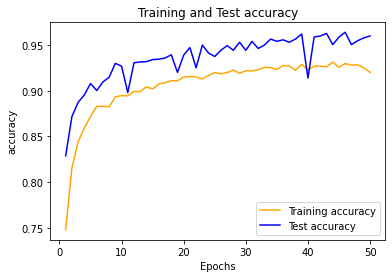

In [21]:
plot_from_history(history.history)

In [22]:
model.save("./models/base_siamese")

INFO:tensorflow:Assets written to: ./models/base_siamese\assets


In [46]:
model.predict([np.array([train_df['inputA'][0]]), np.array([train_df['inputB'][0]])])[0][0]

0.9952236

In [51]:
model.predict([np.array(list(train_df['inputA'])), np.array(list(train_df['inputB']))])

array([0.9952236], dtype=float32)

In [52]:
start = time.time()
preds = [x[0] for x in model.predict([np.array(list(train_df['inputA'])), np.array(list(train_df['inputB']))])]
end = time.time()
train_results = train_df.copy()
train_results['preds'] = preds
print("Done in:", (end-start), "seconds")
print("Average time per pred:", ((end-start)/len(train_df)), "seconds")
train_results.head()

Done in: 1.1645727157592773 seconds
Average time per pred: 1.9582194948113824e-05 seconds


,inputA,inputB,label,preds
0,"[0.24985932948240364, 0.6350656914100974, 0.82...","[0.7820350888855649, 0.3198341320895355, 0.303...",1,0.995224
1,"[0.3447592728071933, 0.7605236831924497, 0.789...","[0.6068565133586963, 0.4892604057585005, 0.647...",1,0.959608
2,"[0.5835598702428237, 0.2923623783944991, 0.494...","[0.7092419823457793, 0.3953920733270686, 0.584...",0,-0.163975
3,"[0.6494945188525626, 0.33861761010055624, 0.29...","[0.412796658774194, 0.6307090412962476, 0.7552...",0,-0.253983
4,"[0.5530646953235432, 0.46914860434629924, 0.48...","[0.605411651622807, 0.5611188390198073, 0.5267...",1,0.972609


<AxesSubplot:title={'center':'preds'}, xlabel='label'>

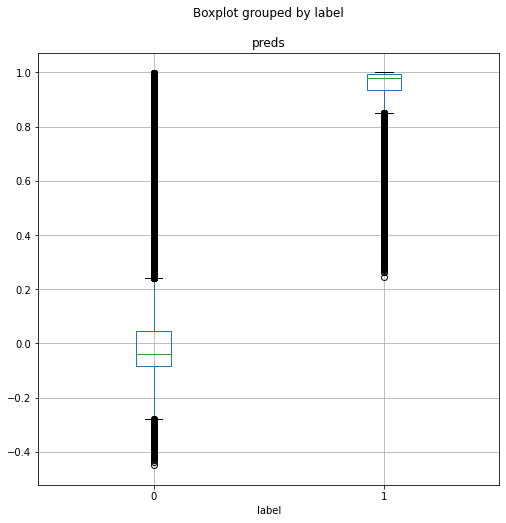

In [54]:
train_results.boxplot('preds', 'label', figsize=(8,8))

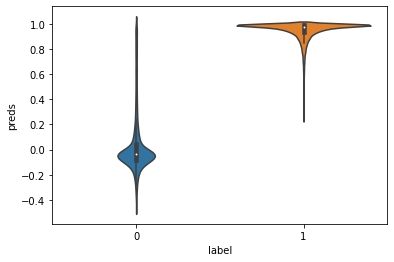

In [56]:
ax = sns.violinplot(x="label", y="preds", data=train_results)

In [70]:
threshold = 0.65
train_results['pred_class'] = train_results.apply(lambda x: int(x['preds']>=threshold), axis=1)
train_results.head()

,inputA,inputB,label,preds,pred_class
0,"[0.24985932948240364, 0.6350656914100974, 0.82...","[0.7820350888855649, 0.3198341320895355, 0.303...",1,0.995224,1
1,"[0.3447592728071933, 0.7605236831924497, 0.789...","[0.6068565133586963, 0.4892604057585005, 0.647...",1,0.959608,1
2,"[0.5835598702428237, 0.2923623783944991, 0.494...","[0.7092419823457793, 0.3953920733270686, 0.584...",0,-0.163975,0
3,"[0.6494945188525626, 0.33861761010055624, 0.29...","[0.412796658774194, 0.6307090412962476, 0.7552...",0,-0.253983,0
4,"[0.5530646953235432, 0.46914860434629924, 0.48...","[0.605411651622807, 0.5611188390198073, 0.5267...",1,0.972609,1


In [71]:
print(confusion_matrix(train_results.label, train_results.pred_class))

[[28130  1651]
 [  423 29267]]


In [72]:
print(classification_report(train_results.label, train_results.pred_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     29781
           1       0.95      0.99      0.97     29690

    accuracy                           0.97     59471
   macro avg       0.97      0.97      0.97     59471
weighted avg       0.97      0.97      0.97     59471



In [73]:
train_results.to_csv('siamese_train_preds.csv', index=False)

In [74]:
start = time.time()
preds = [x[0] for x in model.predict([np.array(list(test_df['inputA'])), np.array(list(test_df['inputB']))])]
end = time.time()
test_results = test_df.copy()
test_results['preds'] = preds
print("Done in:", (end-start), "seconds")
print("Average time per pred:", ((end-start)/len(train_df)), "seconds")
test_results.head()

Done in: 0.5263059139251709 seconds
Average time per pred: 8.849790888419076e-06 seconds


,inputA,inputB,label,preds
0,"[0.7599851760351478, 0.27829568977021635, 0.39...","[0.3881078382392493, 0.6320058758104472, 0.777...",1,0.933248
1,"[0.23891840228138905, 0.19716560358624316, 0.7...","[0.1339817574334914, 0.3268776091606487, 0.788...",1,0.984288
2,"[0.75814829097616, 0.38292398110746095, 0.6330...","[0.3696297750956259, 0.5905143892117646, 0.885...",0,-0.031089
3,"[0.2607263177495158, 0.6446019065053701, 0.742...","[0.729151566561377, 0.1314536503611208, 0.2343...",0,-0.133252
4,"[0.7674167172311745, 0.26044605158506295, 0.08...","[0.8528030713373913, 0.2308533587518186, 0.265...",1,0.931725


In [75]:
threshold = 0.65
test_results['pred_class'] = test_results.apply(lambda x: int(x['preds']>=threshold), axis=1)
test_results.head()

,inputA,inputB,label,preds,pred_class
0,"[0.7599851760351478, 0.27829568977021635, 0.39...","[0.3881078382392493, 0.6320058758104472, 0.777...",1,0.933248,1
1,"[0.23891840228138905, 0.19716560358624316, 0.7...","[0.1339817574334914, 0.3268776091606487, 0.788...",1,0.984288,1
2,"[0.75814829097616, 0.38292398110746095, 0.6330...","[0.3696297750956259, 0.5905143892117646, 0.885...",0,-0.031089,0
3,"[0.2607263177495158, 0.6446019065053701, 0.742...","[0.729151566561377, 0.1314536503611208, 0.2343...",0,-0.133252,0
4,"[0.7674167172311745, 0.26044605158506295, 0.08...","[0.8528030713373913, 0.2308533587518186, 0.265...",1,0.931725,1


In [76]:
print(confusion_matrix(test_results.label, test_results.pred_class))

[[11981   718]
 [  177 12612]]


In [77]:
print(classification_report(test_results.label, test_results.pred_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     12699
           1       0.95      0.99      0.97     12789

    accuracy                           0.96     25488
   macro avg       0.97      0.96      0.96     25488
weighted avg       0.97      0.96      0.96     25488



In [78]:
test_results.to_csv('siamese_test_preds.csv', index=False)